<a href="https://colab.research.google.com/github/Medamine-mzk/D-tection-de-communaut-s-probabilistes-dans-les-r-seaux-sociaux---Mod-le-probabiliste-propos-/blob/main/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install fuzzy-c-means


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: typer
    Found existing installation: typer 0.12.3
    Uninstalling typer-0.12.3:
      Successfully uninstalled typer-0.12.3
  Attempting uninstall: tabulate
    Found existing installation: tabulate 0.9.0
    Uninstalling tabulate-0.9.0:
      Successfully uninstalled tabulate-0.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.13.0 requires tabulate>=0.9, but you have tabulate 0.8.10 which is incompatible.


Saving traffic_flow_data.csv to traffic_flow_data (3).csv
     source  target  congestion_factor
0         0      90           3.130946
1         0      41           3.852845
2         1      61           2.472110
3         1      89           2.929812
4         1      66           2.702477
..      ...     ...                ...
195      85      89           3.033137
196      86      98           1.802797
197      88      90           2.844135
198      93      94           2.295642
199      94      99           2.894224

[200 rows x 3 columns]


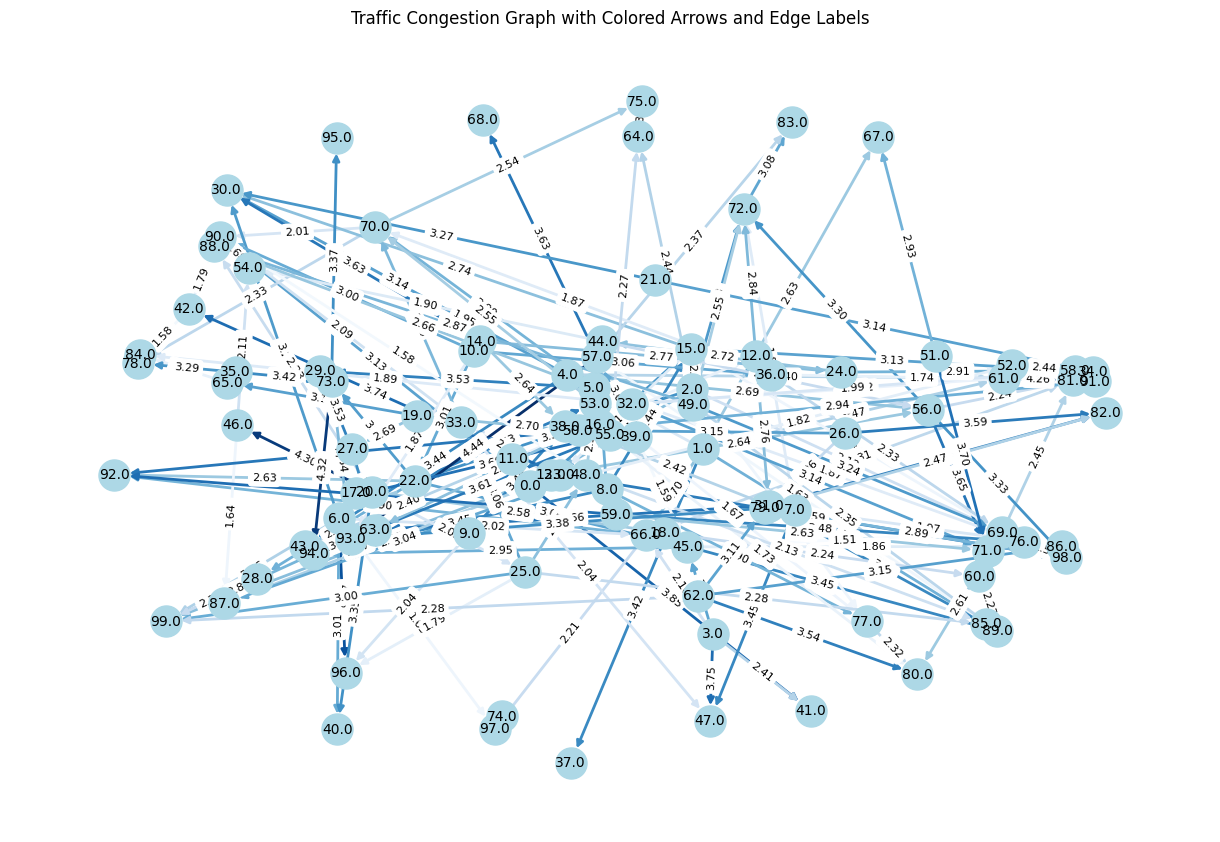

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


K-Means Silhouette Score: 0.5600413292594848
K-Means Davies-Bouldin Index: 0.5319897200864169
K-Means Calinski-Harabasz Index: 600.8484183215154


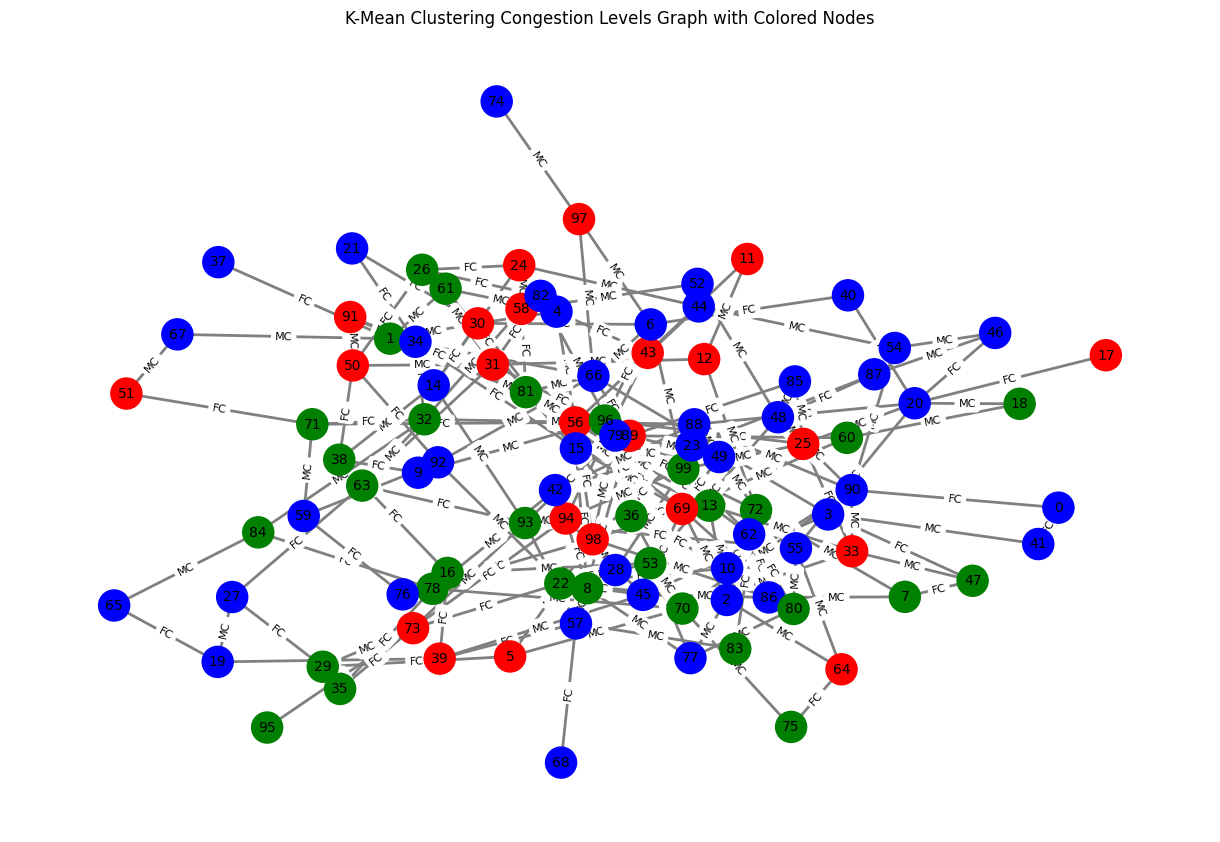

FCM Silhouette Score: 0.5594943164261957
FCM Davies-Bouldin Index: 0.53210550942757
FCM Calinski-Harabasz Index: 599.9421520487037


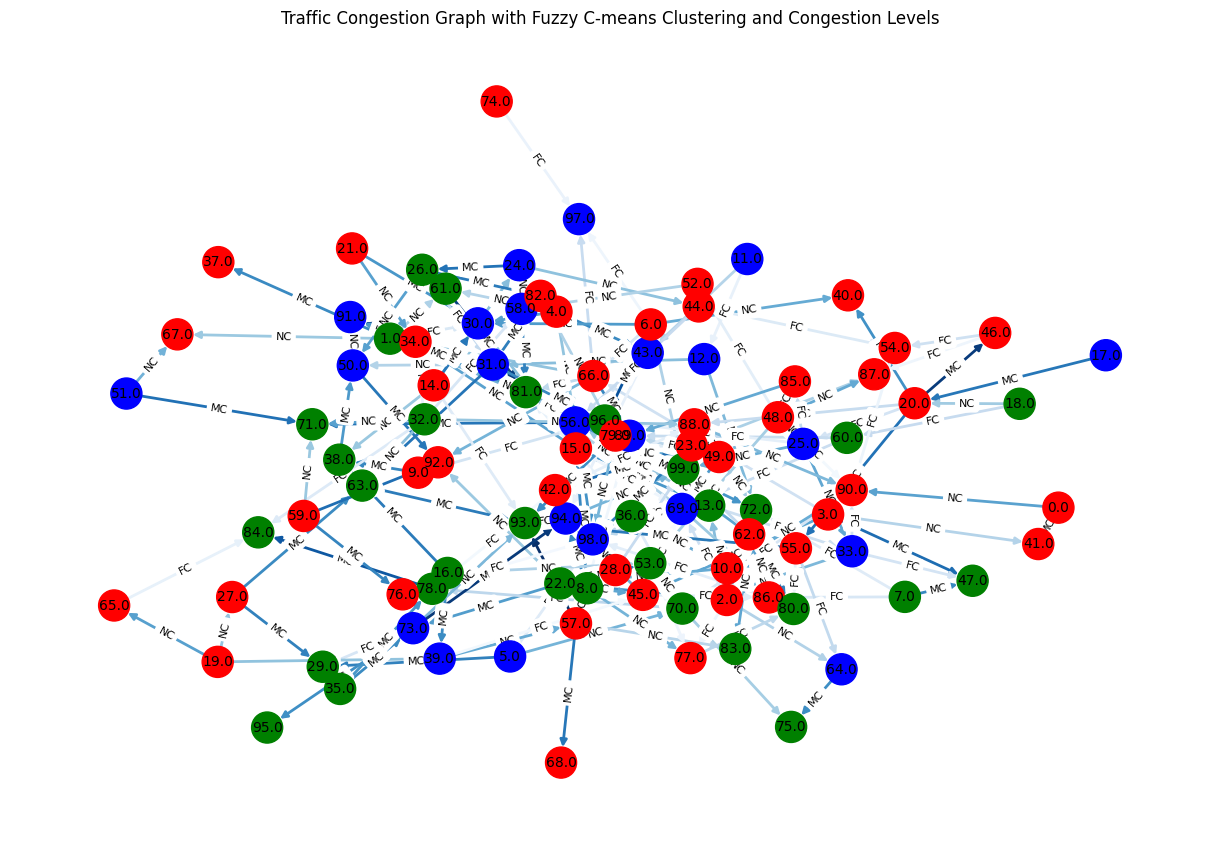

Spectral Clustering Silhouette Score: -0.05185330296163107
Spectral Clustering Davies-Bouldin Index: 14.547350878652859
Spectral Clustering Calinski-Harabasz Index: 0.49741234334941364


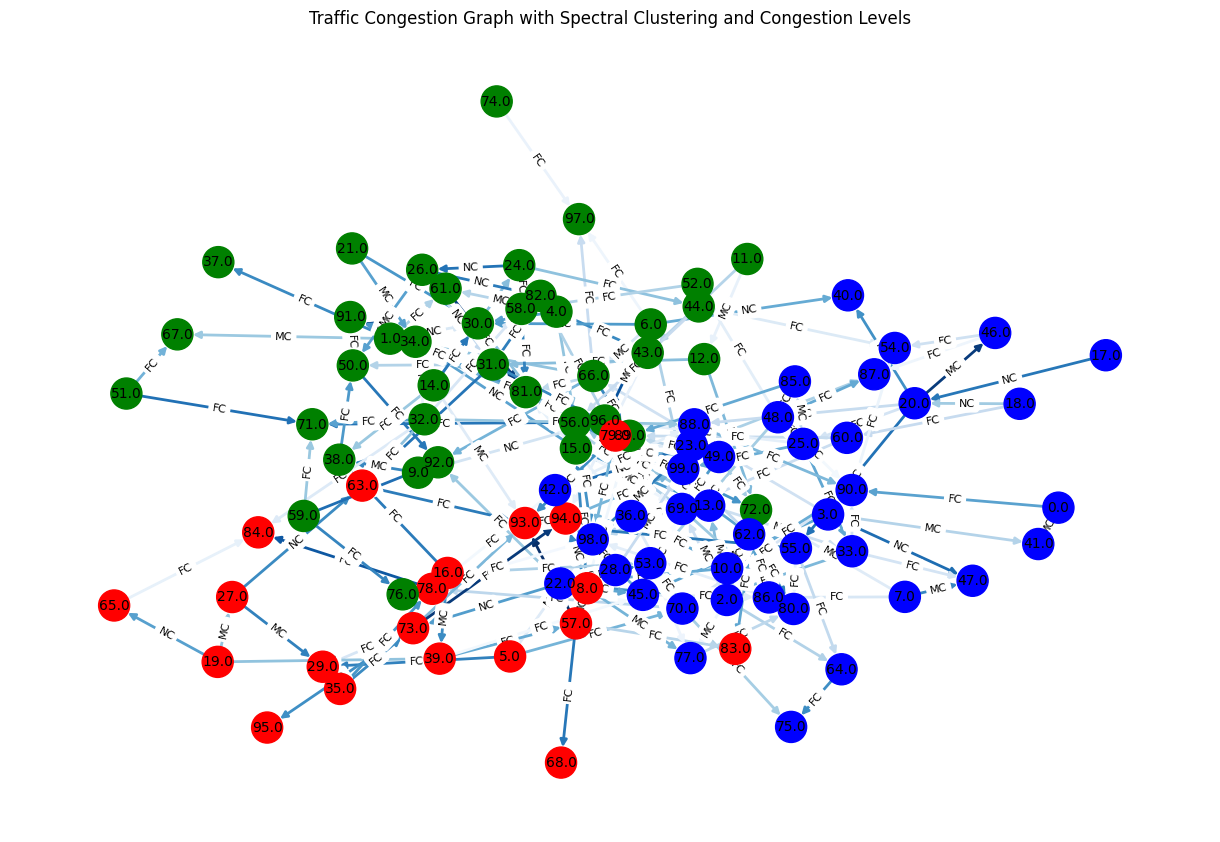

In [6]:
from google.colab import files
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np
import pandas as pd
from fcmeans import FCM

# Upload the file
uploaded = files.upload()

# Load the uploaded CSV file
df = pd.read_csv('traffic_flow_data.csv')
df = df[['source', 'target', 'congestion_factor']]
print(df)

# Create a directed graph
G = nx.DiGraph()

# Add edges with congestion_factor as weight
for _, row in df.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['congestion_factor'])

# Draw the first graph (Traffic Congestion Graph)
plt.figure(figsize=(12, 8))  # Increase the figure size

# Define the positions for nodes
pos = nx.spring_layout(G)

# Get edge weights for coloring
weights = [G[u][v]['weight'] for u, v in G.edges()]

# Draw the nodes
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10,
        edge_color=weights, edge_cmap=plt.cm.Blues, width=2, edge_vmin=min(weights), edge_vmax=max(weights))

# Prepare edge labels with two decimal places
edge_labels = {edge: f"{G[edge[0]][edge[1]]['weight']:.2f}" for edge in G.edges()}

# Draw the edge labels (congestion factor with two decimal places)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Traffic Congestion Graph with Colored Arrows and Edge Labels")
plt.show()

# Extract congestion factor for clustering
X = df['congestion_factor'].values.reshape(-1, 1)

# Apply K-means clustering
kmeans = KMeans(n_clusters=3)  # Adjust the number of clusters as needed
df['cluster'] = kmeans.fit_predict(X)

# Evaluation Metrics for K-Means
kmeans_silhouette = silhouette_score(X, df['cluster'])
kmeans_db = davies_bouldin_score(X, df['cluster'])
kmeans_ch = calinski_harabasz_score(X, df['cluster'])

print(f'K-Means Silhouette Score: {kmeans_silhouette}')
print(f'K-Means Davies-Bouldin Index: {kmeans_db}')
print(f'K-Means Calinski-Harabasz Index: {kmeans_ch}')

# Define congestion levels
def congestion_level(factor):
    if factor < 1:  # Example threshold for No Congestion
        return 'NC'
    elif factor < 3:  # Example threshold for Medium Congestion
        return 'MC'
    else:
        return 'FC'

df['congestion_level'] = df['congestion_factor'].apply(congestion_level)

# Create a new graph for congestion levels
G2 = nx.Graph()

# Add edges with congestion levels as labels
for _, row in df.iterrows():
    G2.add_edge(row['source'], row['target'], label=row['congestion_level'])

# Define colors for K-means clusters
kmeans_colors = ['red', 'green', 'blue']

# Assign colors to nodes based on their K-means cluster
kmeans_node_colors = [kmeans_colors[int(df['cluster'].loc[node])] if node in df['cluster'].index and int(df['cluster'].loc[node]) in range(len(kmeans_colors)) else 'gray' for node in G2.nodes()]

# Draw the second graph (Congestion Levels Graph)
plt.figure(figsize=(12, 8))  # Increase the figure size before drawing the graph

pos = nx.spring_layout(G2)
edge_labels = nx.get_edge_attributes(G2, 'label')

# Draw nodes with colors based on K-means clusters
nx.draw(G2, pos, with_labels=True, node_color=kmeans_node_colors, edge_color='gray', width=2, node_size=500, font_size=10)

# Draw edge labels
nx.draw_networkx_edge_labels(G2, pos, edge_labels=edge_labels, font_size=8)

plt.title("K-Mean Clustering Congestion Levels Graph with Colored Nodes")
plt.show()

#--------------------------------------------------
# Fuzzy C-means Clustering
fcm = FCM(n_clusters=3)
fcm.fit(X)

# Get the soft membership degrees and predict clusters
fcm_labels = fcm.predict(X)

# Add the FCM clusters to the DataFrame
df['fcm_cluster'] = fcm_labels

# Evaluation Metrics for Fuzzy C-Means
fcm_silhouette = silhouette_score(X, fcm_labels)
fcm_db = davies_bouldin_score(X, fcm_labels)
fcm_ch = calinski_harabasz_score(X, fcm_labels)

print(f'FCM Silhouette Score: {fcm_silhouette}')
print(f'FCM Davies-Bouldin Index: {fcm_db}')
print(f'FCM Calinski-Harabasz Index: {fcm_ch}')

# Function to assign congestion levels based on FCM cluster
def fcm_congestion_level(cluster_label):
    if cluster_label == 0:
        return 'NC'  # No Congestion
    elif cluster_label == 1:
        return 'MC'  # Medium Congestion
    else:
        return 'FC'  # Full Congestion
# Apply the function to the DataFrame
df['fcm_congestion_level'] = df['fcm_cluster'].apply(fcm_congestion_level)

# Define the color map for clusters
colors = ['red', 'green', 'blue']

# Assign colors to nodes based on their FCM cluster
fcm_node_colors = [colors[int(df['fcm_cluster'].loc[node])] if node in df['fcm_cluster'].index and int(df['fcm_cluster'].loc[node]) in range(len(colors)) else 'gray' for node in G.nodes()]

# Draw the graph with FCM clusters
plt.figure(figsize=(12, 8))  # Increase the figure size

nx.draw(G, pos, with_labels=True, node_color=fcm_node_colors, node_size=500, font_size=10,
        edge_color=weights, edge_cmap=plt.cm.Blues, width=2, edge_vmin=min(weights), edge_vmax=max(weights))

# Draw edge labels with congestion levels based on FCM clustering
edge_labels = {edge: df.loc[(df['source'] == edge[0]) & (df['target'] == edge[1]), 'fcm_congestion_level'].values[0]
              for edge in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Traffic Congestion Graph with Fuzzy C-means Clustering and Congestion Levels")
plt.show()

#-----------------------------------------------------------------------------------------------
# ------------ Spectral clustering ----------------------------
# Ensure adjacency matrix is symmetric
adj_matrix = nx.to_numpy_array(G)
adj_matrix = (adj_matrix + adj_matrix.T) / 2  # Make sure the matrix is symmetric

# Apply Spectral Clustering
spectral_clustering = SpectralClustering(n_clusters=3, affinity='precomputed', assign_labels='kmeans')

# Fit the model and predict the clusters
cluster_labels = spectral_clustering.fit_predict(adj_matrix)

# Convert cluster labels to integers and handle NaN values
cluster_labels = np.nan_to_num(cluster_labels, nan=-1).astype(int)

# Ensure that df['spectral_cluster'] has the same length as the number of nodes in G
df['spectral_cluster'] = pd.Series(cluster_labels, index=G.nodes())

# For evaluation, create a node feature matrix using the average congestion factor connected to each node
# Calculate the average congestion factor for each node
node_congestion = df.groupby('source')['congestion_factor'].mean()

# Ensure all nodes are covered
node_congestion = node_congestion.reindex(G.nodes(), fill_value=0).values.reshape(-1, 1)

# Evaluation Metrics for Spectral Clustering
spectral_silhouette = silhouette_score(node_congestion, cluster_labels)
spectral_db = davies_bouldin_score(node_congestion, cluster_labels)
spectral_ch = calinski_harabasz_score(node_congestion, cluster_labels)

print(f'Spectral Clustering Silhouette Score: {spectral_silhouette}')
print(f'Spectral Clustering Davies-Bouldin Index: {spectral_db}')
print(f'Spectral Clustering Calinski-Harabasz Index: {spectral_ch}')

# Function to assign congestion levels based on Spectral Clustering
def spectral_congestion_level(cluster_label):
    if cluster_label == 0:
        return 'NC'  # No Congestion
    elif cluster_label == 1:
        return 'MC'  # Medium Congestion
    else:
        return 'FC'  # Full Congestion

# Apply the function to the DataFrame
df['spectral_congestion_level'] = df['spectral_cluster'].apply(spectral_congestion_level)

# Assign colors to nodes based on their spectral cluster, handle potential out-of-range indices
node_colors = [colors[int(df['spectral_cluster'].loc[node])] if node in df['spectral_cluster'].index and int(df['spectral_cluster'].loc[node]) in range(len(colors)) else 'gray' for node in G.nodes()]

# Draw the graph with spectral clusters
plt.figure(figsize=(12, 8))  # Increase the figure size

nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=500, font_size=10,
        edge_color=weights, edge_cmap=plt.cm.Blues, width=2, edge_vmin=min(weights), edge_vmax=max(weights))

# Draw edge labels with congestion levels based on Spectral Clustering
edge_labels = {edge: df.loc[(df['source'] == edge[0]) & (df['target'] == edge[1]), 'spectral_congestion_level'].values[0]
              for edge in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Traffic Congestion Graph with Spectral Clustering and Congestion Levels")
plt.show()


The three graphs you’ve shared illustrate the results of K-means, Fuzzy C-means, and Spectral Clustering applied to a traffic congestion network. Here's a brief comparison of the three clustering methods based on the visualizations:

**K-Means Clustering:**

**Observations**: The K-Means clustering divides the nodes into distinct clusters with clear boundaries. However, K-means might struggle with complex data structures due to its assumption of spherical clusters.

**Interpretation**: This approach might be useful if the congestion data is relatively simple and can be separated into well-defined regions.

**Fuzzy C-Means Clustering:**

**Observations**: The Fuzzy C-means clustering results show overlapping clusters where nodes have membership degrees in multiple clusters. This approach can be beneficial for traffic data where congestion patterns are not strictly separable, allowing for a more flexible representation of congestion levels.

**Interpretation**: This method captures the inherent uncertainty and variability in traffic congestion, making it suitable if the goal is to model traffic dynamics where nodes (roads) may belong to multiple congestion states.

**Spectral Clustering:**

**Observations**: Spectral Clustering groups the nodes more tightly, particularly in terms of connected components in the graph. It is effective in handling non-convex shapes and complex data structures.

**Interpretation:** This method is likely the best choice for scenarios where the data has a complex structure, such as when traffic congestion follows intricate patterns that K-means might oversimplify.



---



---



## **To choose the best clustering method, consider evaluating them using metrics like silhouette score, Davies-Bouldin index, or a domain-specific measure that evaluates the quality of clustering in terms of traffic congestion (e.g., comparing with known traffic patterns).**




# **Silhouette Score**
**What it Measures:**
The Silhouette Score evaluates how similar an object is to its own cluster (cohesion) compared to other clusters (separation).

The score ranges from -1 to 1. A high score indicates that the objects are well matched to their own cluster and poorly matched to neighboring clusters.

# **Davies-Bouldin Index**
**What it Measures:**
The Davies-Bouldin Index measures the average similarity ratio of each cluster with the cluster that is most similar to it.

A lower Davies-Bouldin index indicates better clustering.

# **Calinski-Harabasz Index (Variance Ratio Criterion)**
**What it Measures:**
This index measures the ratio of the sum of between-cluster dispersion and of within-cluster dispersion.

A higher score generally indicates better-defined clusters.